In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel,ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
checkpoint='google/vit-base-patch16-224-in21k'

In [4]:
from datasets import load_dataset

dataset=load_dataset('Matthijs/snacks')
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})


In [5]:
#Now writing a dataset for this dataset
import torch.nn as nn

class Snacks_Dataset(torch.utils.data.Dataset):
  def __init__(self,dataset,transform=None):
    self.dataset=dataset
    self.transform=transform
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self,idx):
    image=self.dataset[idx]['image']
    labels=self.dataset[idx]['label']

    if self.transform!=None:
      image=self.transform(image)

      return image,labels
    return image,labels


In [6]:
from torchvision import transforms

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224,224),antialias=True),
        transforms.Normalize(mean=[0.5,0.5,0.5],
                             std=[0.5,0.5,0.5]
                             )
    ]
)

In [7]:
trainset=Snacks_Dataset(dataset['train'],transform)
validset=Snacks_Dataset(dataset['validation'],transform)
testset=Snacks_Dataset(dataset['test'],transform)

In [8]:
print(f"Length of the Training Set {len(trainset)}")
print(f"Length of the Validation Set {len(validset)}")
print(f"Length of the Test Set {len(testset)}")

Length of the Training Set 4838
Length of the Validation Set 955
Length of the Test Set 952


In [9]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=8,shuffle=False)
validloader=torch.utils.data.DataLoader(validset,batch_size=8,shuffle=False)

In [10]:
for data in trainloader:
  image,label=data
  break

print(f"One batch image size: {image.shape} ")
print(f"One batch label size: {label.shape}")

One batch image size: torch.Size([8, 3, 224, 224]) 
One batch label size: torch.Size([8])


In [11]:

class SnackVit(nn.Module):
  def __init__(self,config=ViTConfig(),num_labels=1024,checkpoint=checkpoint):
    super(SnackVit,self).__init__()
    self.vit=ViTModel.from_pretrained(checkpoint,add_pooling_layer=False)
    self.classifier=nn.Linear(config.hidden_size,num_labels)

  def forward(self,image):
    x=self.vit(image)['last_hidden_state']
    out=self.classifier(x[:,0,:])

    return out

In [12]:
model=SnackVit()
model.to('cuda');

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
torch.cuda.empty_cache()

In [14]:
! pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.0 MB/s eta 0:00:00


In [15]:
timm.list_models(pretrained=True);

In [16]:
class CNNmodel(nn.Module):
  def __init__(self,model_name="inception_v4.tf_in1k"):
    super(CNNmodel,self).__init__()
    self.model= timm.create_model(model_name=model_name,pretrained=True,num_classes=1024)
    #self.classifier=nn.Linear(1024,1024)
  def forward(self,image):
    feature=self.model(image)
    #out=self.classifier(feature)
    return feature


In [17]:
cmodel=CNNmodel()
cmodel.to('cuda');


In [18]:
output=cmodel(torch.randn((16,3,224,224)).to('cuda'))
print(output.shape)

torch.Size([16, 1024])


In [ ]:
x_train=[]
y_train=[]
for image,label in trainloader:
  image=image.to('cuda')
  label=label.to('cuda')
  output=model(image)
  #Now appending the output to x_train
  output=output.detach().cpu().numpy()
  x_train.append(output)
  label=label.cpu().detach().numpy()
  #label=label.numpy()
  label=label.astype('int')
  y_train.append(label)
  torch.cuda.empty_cache()

# Extracting Training Features

In [19]:
from itertools import chain
def training_feature_extractor(model,trainloader,send_label=False):
  x_train=[]
  y_train=[]
  for image,label in tqdm(trainloader):
    image=image.to('cuda')
    label=label.to('cuda')
    output=model(image)
    output=output.detach().cpu().numpy()
    x_train.append(output)
    label=label.cpu().detach().numpy()
    label=label.astype('int')
    y_train.append(label)
    torch.cuda.empty_cache()

  x_train_features=list(chain.from_iterable(x_train))
  y_train=list(chain.from_iterable(y_train))
  print("Total Training elements: ",len(x_train_features))
  print("Total Training Labels: ",len(y_train))
  x_train_features = np.array(x_train_features)
  y_train=np.array(y_train)
  print("Shape of Training Labels: ",y_train.shape)
  if send_label==False:
    return x_train_features

  return x_train_features,y_train

In [ ]:
from itertools import chain

x_train_features=list(chain.from_iterable(x_train))
y_train=list(chain.from_iterable(y_train))


In [20]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1870 MiB |   1927 MiB |   4234 MiB |   2364 MiB |\n|       from large pool |   1808 MiB |   1896 MiB |   4148 MiB |   2340 MiB |\n|       from small pool |     62 MiB |     63 MiB |     85 MiB |     23 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   1870 MiB |   1927 MiB |   4234 MiB |   2364 MiB |\n|       from large pool |   1808 MiB |   1896 MiB |

In [21]:
#Feature extracton cnn
cnn_feature,cnn_labels=training_feature_extractor(cmodel,trainloader,send_label=True)

100%|██████████| 605/605 [01:44<00:00,  5.77it/s]

Total Training elements:  4838
Total Training Labels:  4838
Shape of Training Labels:  (4838,)


In [22]:
vit_feature,vit_labels=training_feature_extractor(model,trainloader,send_label=True)

100%|██████████| 605/605 [01:50<00:00,  5.47it/s]

Total Training elements:  4838
Total Training Labels:  4838
Shape of Training Labels:  (4838,)


In [24]:
print(np.array_equal(vit_labels,cnn_labels))

True


In [25]:
concat_feature_train=np.concatenate((cnn_feature,vit_feature),axis=1)
print(concat_feature_train.shape)

(4838, 2048)


In [26]:
y_train=cnn_labels
print("Total training labels ",len(y_train))

Total training labels  4838


In [ ]:
print("Total Training elements: ",len(x_train_features))
print("Total Training Labels: ",len(y_train))

In [ ]:
x_train_features = np.array(x_train_features)
print("Shape of training features: ",x_train_features.shape)

In [ ]:
y_train=np.array(y_train)
print("Shape of Training Labels: ",y_train.shape)

In [ ]:
#Converting them to pandas and saving them
label_train=y_train.tolist()
df_train=pd.DataFrame(x_train_features)
df_train=df_train.assign(labels=label_train)
df_train.head()

In [ ]:
df_train.describe()

In [ ]:
df_train.to_csv("Training_Features.csv",index=False)

# Extracting Test Features

In [ ]:
x_test=[]
y_test=[]
for image,label in validloader:
  image=image.to('cuda')
  label=label.to('cuda')
  output=model(image)
  #Now appending the output to x_train
  output=output.detach().cpu().numpy()
  x_test.append(output)
  label=label.cpu().detach().numpy()
  #label=label.numpy()
  label=label.astype('int')
  y_test.append(label)
  torch.cuda.empty_cache()

In [27]:
def test_loader_feature_extraction(model,testloader=validloader,send_label=False):
  x_test=[]
  y_test=[]
  for image,label in tqdm(testloader):
    image=image.to('cuda')
    label=label.to('cuda')
    output=model(image)
    output=output.detach().cpu().numpy()
    x_test.append(output)
    label=label.cpu().detach().numpy()
    label=label.astype('int')
    y_test.append(label)
    torch.cuda.empty_cache()
  x_val_features=list(chain.from_iterable(x_test))
  y_val=list(chain.from_iterable(y_test))
  print("Total Training elements: ",len(x_val_features))
  print("Total Training Labels: ",len(y_val))
  x_val_features = np.array(x_val_features)
  print("Shape of Testing features: ",x_val_features.shape)
  y_val=np.array(y_val)
  print("Shape of Training Labels: ",y_val.shape)
  if send_label==False:
    return x_val_features
  return x_val_features,y_val

In [ ]:
from itertools import chain

x_val_features=list(chain.from_iterable(x_test))
y_val=list(chain.from_iterable(y_test))


In [ ]:
print("Total Training elements: ",len(x_val_features))
print("Total Training Labels: ",len(y_val))

In [ ]:
x_val_features = np.array(x_val_features)
print("Shape of Testing features: ",x_val_features.shape)

In [ ]:
y_val=np.array(y_val)
print("Shape of Training Labels: ",y_val.shape)

In [28]:
cnn_test_feature,test_cnn_label=test_loader_feature_extraction(cmodel,send_label=True)

100%|██████████| 120/120 [00:31<00:00,  3.76it/s]

Total Training elements:  955
Total Training Labels:  955
Shape of Testing features:  (955, 1024)
Shape of Training Labels:  (955,)


In [29]:
vit_test_feature,test_vit_label=test_loader_feature_extraction(model,send_label=True)

100%|██████████| 120/120 [00:21<00:00,  5.48it/s]

Total Training elements:  955
Total Training Labels:  955
Shape of Testing features:  (955, 1024)
Shape of Training Labels:  (955,)


In [30]:
print(np.array_equal(test_cnn_label,test_vit_label))

True


In [31]:
concat_feature_test=np.concatenate((cnn_test_feature,vit_test_feature),axis=1)
print(concat_feature_test.shape)

(955, 2048)


In [32]:
y_val=test_cnn_label

In [ ]:
print(y_val.shape)

In [ ]:
#Converting them to pandas and saving them
label_val=y_val.tolist()
df_val=pd.DataFrame(x_val_features)
df_val=df_val.assign(labels=label_val)
df_val.head()

In [ ]:
df_val.describe()

In [ ]:
df_val.to_csv("Validation Features.csv",index=False)

# Data Preprocessing

In [33]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_train=sc.fit_transform(concat_feature_train)
X_val=sc.transform(concat_feature_test)

print("After scaling train: ", X_train.shape)
print("After scaling test size: ", X_val.shape)

After scaling train:  (4838, 2048)
After scaling test size:  (955, 2048)


In [34]:
for temp, temp1 in zip(test_cnn_label,test_vit_label):
  if temp!=temp1:
    print("Not matched")

# Classification with MLP

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
mlp_classifier=MLPClassifier(hidden_layer_sizes=(4000,),learning_rate_init=0.0001,random_state=42,max_iter=2000000)

mlp_classifier.fit(X_train,y_train)

predictions=mlp_classifier.predict(X_val)
val_acc=accuracy_score(y_val,predictions)
print(val_acc)


0.93717277486911


In [ ]:
print(predictions.shape)

In [39]:
print("Test Accuracy ",round(val_acc,3))

Test Accuracy  0.937


In [41]:
from sklearn.metrics import roc_auc_score
roc_score=roc_auc_score(y_val,mlp_classifier.predict_proba(X_val),multi_class='ovr')

print(roc_score)

0.9975708691845547


In [42]:
classes=dataset["train"].features['label'].names
print(classes)

['apple', 'banana', 'cake', 'candy', 'carrot', 'cookie', 'doughnut', 'grape', 'hot dog', 'ice cream', 'juice', 'muffin', 'orange', 'pineapple', 'popcorn', 'pretzel', 'salad', 'strawberry', 'waffle', 'watermelon']


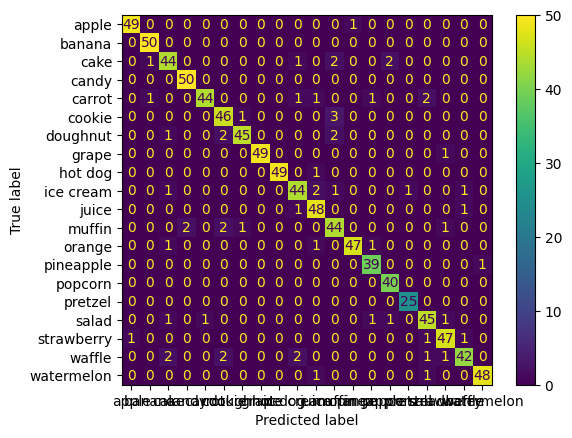

In [43]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val,predictions,display_labels=classes)


<Figure size 10000x10000 with 0 Axes>

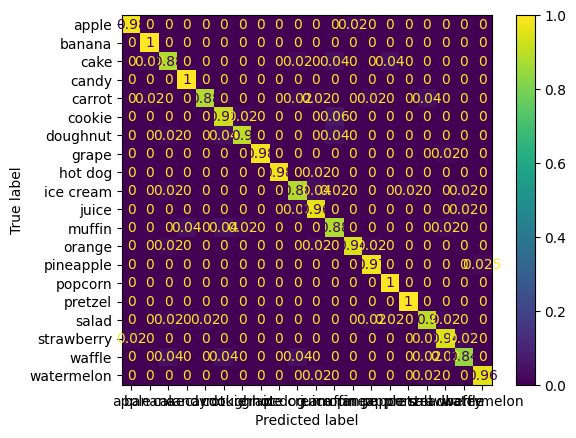

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(100,100))
ConfusionMatrixDisplay.from_predictions(y_val,predictions,display_labels=classes,normalize='true',)

In [45]:
from sklearn.metrics import classification_report
rep=classification_report(y_val,predictions)
print(rep)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.96      1.00      0.98        50
           2       0.88      0.88      0.88        50
           3       0.96      1.00      0.98        50
           4       0.98      0.88      0.93        50
           5       0.88      0.92      0.90        50
           6       0.96      0.90      0.93        50
           7       1.00      0.98      0.99        50
           8       1.00      0.98      0.99        50
           9       0.90      0.88      0.89        50
          10       0.89      0.96      0.92        50
          11       0.85      0.88      0.86        50
          12       0.98      0.94      0.96        50
          13       0.93      0.97      0.95        40
          14       0.93      1.00      0.96        40
          15       0.96      1.00      0.98        25
          16       0.90      0.90      0.90        50
          17       0.92    

# Classification With Support Vector Machine

In [46]:
from sklearn.svm import SVC
svm_classifier=SVC(C=1,kernel='sigmoid',random_state=42,gamma='scale',coef0=0.02,probability=True)
svm_classifier.fit(X_train,y_train)
predic_svm=svm_classifier.predict(X_val)
val_acc_svm=accuracy_score(y_val,predic_svm)
print(val_acc_svm)

0.9350785340314136


In [47]:
print("Test Accuracy ",round(val_acc_svm,3))

Test Accuracy  0.935


In [48]:
from sklearn.metrics import roc_auc_score
roc_score=roc_auc_score(y_val,svm_classifier.predict_proba(X_val),multi_class='ovr')

print(roc_score)

0.9977164040092987


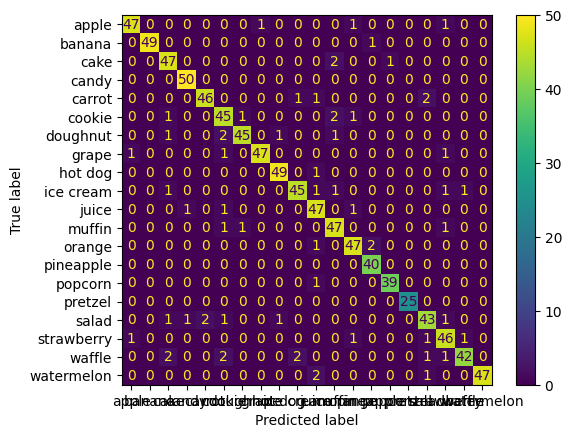

In [49]:
ConfusionMatrixDisplay.from_predictions(y_val,predic_svm,display_labels=classes)

In [50]:
from sklearn.metrics import classification_report
report=classification_report(y_val,predic_svm,target_names=classes)
print(report)

              precision    recall  f1-score   support

       apple       0.96      0.94      0.95        50
      banana       1.00      0.98      0.99        50
        cake       0.89      0.94      0.91        50
       candy       0.96      1.00      0.98        50
      carrot       0.96      0.92      0.94        50
      cookie       0.85      0.90      0.87        50
    doughnut       0.96      0.90      0.93        50
       grape       0.98      0.94      0.96        50
     hot dog       0.96      0.98      0.97        50
   ice cream       0.94      0.90      0.92        50
       juice       0.87      0.94      0.90        50
      muffin       0.89      0.94      0.91        50
      orange       0.92      0.94      0.93        50
   pineapple       0.93      1.00      0.96        40
     popcorn       0.97      0.97      0.97        40
     pretzel       1.00      1.00      1.00        25
       salad       0.90      0.86      0.88        50
  strawberry       0.88    

# K-Fold Cross Validation

In [51]:
from sklearn.model_selection import cross_val_score

results=cross_val_score(estimator=mlp_classifier,X=X_train,y=y_train,cv=5,verbose=1)
k_fold_mean=results.mean()
print("Mean accuracy for fold -5",round(k_fold_mean,3))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean accuracy for fold -5 0.932
Mean accuracy for fold -5 0.932


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.2min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.2min finished


In [52]:
predict_mlp=mlp_classifier.predict(X_val)
test_acc1=accuracy_score(y_val,predict_mlp)
print("Test accuracy: ",test_acc1)

Test accuracy:  0.93717277486911


In [53]:
results=cross_val_score(estimator=svm_classifier,X=X_train,y=y_train,cv=5,verbose=1)
k_fold_mean=results.mean()
print("Mean accuracy for fold-5 ",round(k_fold_mean,3))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean accuracy for fold-5  0.927


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [54]:
predict_svm=svm_classifier.predict(X_val)
test_acc2=accuracy_score(y_val,predict_svm)
print("Test accuracy: ",test_acc2)

Test accuracy:  0.9350785340314136


# Feature Selection Technique
**Principal Component Analysis**

# PCA 400

In [55]:
from sklearn.decomposition import PCA
pca=PCA(n_components=400)
x_train_pca=pca.fit_transform(X_train)
x_test_pca=pca.transform(X_val)

mlp_clf=MLPClassifier(hidden_layer_sizes=(3000,),learning_rate_init=0.0001,max_iter=2000000,random_state=42)

mlp_clf.fit(x_train_pca,y_train)

y_pred1=mlp_clf.predict(x_test_pca)
test_acc=accuracy_score(y_val,y_pred1)

print("Test accuracy: ",round(test_acc,3))

Test accuracy:  0.94


**pca 100**

In [56]:
from sklearn.decomposition import PCA
pca=PCA(n_components=100)
x_train_pca=pca.fit_transform(X_train)
x_test_pca=pca.transform(X_val)

mlp_clf=MLPClassifier(hidden_layer_sizes=(3000,),learning_rate_init=0.0001,max_iter=2000000,random_state=42)

mlp_clf.fit(x_train_pca,y_train)

y_pred1=mlp_clf.predict(x_test_pca)
test_acc=accuracy_score(y_val,y_pred1)

print("Test accuracy: ",round(test_acc,3))

Test accuracy:  0.92


# pca 900

In [57]:
from sklearn.decomposition import PCA
pca=PCA(n_components=900)
x_train_pca=pca.fit_transform(X_train)
x_test_pca=pca.transform(X_val)

mlp_clf=MLPClassifier(hidden_layer_sizes=(3000,),learning_rate_init=0.0001,max_iter=2000000,random_state=42)

mlp_clf.fit(x_train_pca,y_train)

y_pred1=mlp_clf.predict(x_test_pca)
test_acc=accuracy_score(y_val,y_pred1)

print("Test accuracy: ",round(test_acc,3))

Test accuracy:  0.938


# PCA 1200

In [58]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1200)
x_train_pca=pca.fit_transform(X_train)
x_test_pca=pca.transform(X_val)

mlp_clf=MLPClassifier(hidden_layer_sizes=(3000,),learning_rate_init=0.0001,max_iter=2000000,random_state=42)

mlp_clf.fit(x_train_pca,y_train)

y_pred1=mlp_clf.predict(x_test_pca)
test_acc=accuracy_score(y_val,y_pred1)

print("Test accuracy: ",round(test_acc,3))

Test accuracy:  0.942


# PCA 1300

In [59]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1400)
x_train_pca=pca.fit_transform(X_train)
x_test_pca=pca.transform(X_val)

mlp_clf=MLPClassifier(hidden_layer_sizes=(3000,),learning_rate_init=0.0001,max_iter=2000000,random_state=42)

mlp_clf.fit(x_train_pca,y_train)

y_pred1=mlp_clf.predict(x_test_pca)
test_acc=accuracy_score(y_val,y_pred1)

print("Test accuracy: ",round(test_acc,3))

Test accuracy:  0.942


# Using UMAP

In [ ]:
! pip install umap_learn

In [67]:
from sklearn.manifold import TSNE
import umap
tsne=umap.UMAP(n_components=400,n_neighbors=15,random_state=42)
x_train_tsne=tsne.fit_transform(X_train)
x_test_tsne=tsne.transform(X_val)
mlp_clf=MLPClassifier(hidden_layer_sizes=(3000,),learning_rate_init=0.0001,max_iter=2000000,random_state=42)
mlp_clf.fit(x_train_tsne,y_train)
y_pred1=mlp_clf.predict(x_test_tsne)
test_acc=accuracy_score(y_val,y_pred1)
print("test accuracy: ",round(test_acc,3))

test accuracy:  0.803
